<a href="https://colab.research.google.com/github/Tushar-Thakur01/Hybrid-Extractive-Abstractive-Summarization-System/blob/main/Hybrid_Extractive_Abstractive_Summarization_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%capture
!pip -q install "transformers==4.44.2" "datasets==2.21.0" "accelerate==0.34.2" \
                "sentence-transformers==3.0.1" "peft==0.12.0" \
                "evaluate==0.4.3" rouge_score==0.1.2 bert_score==0.3.13 \
                nltk==3.9.1 matplotlib==3.9.2 "tqdm>=4.66.4"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 72.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages 

In [ ]:
import os, re, random, math, time, gc, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

import torch, torch.nn.functional as F
from tqdm.auto import tqdm

import nltk
nltk.download('punkt', quiet=True)

from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer, CrossEncoder
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          DataCollatorForSeq2Seq, Trainer, TrainingArguments)
from peft import LoraConfig, get_peft_model
import evaluate
from bert_score import score as bertscore_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
print("Device:", DEVICE)

OUT_DIR = "hybrid_fast_runs"
os.makedirs(OUT_DIR, exist_ok=True)


Device: cuda


In [ ]:
# Token budgets (safe for ~15GB VRAM; adjust if needed)
MAX_INPUT_LEN  = 640
MAX_TARGET_LEN = 150

# Choose extractor mode: "fast"=reranker, "ultra_fast"=no reranker
EXTRACTOR_MODE = "fast"

# We’ll fine-tune BOTH small generators below
GENERATORS = {
    "distilbart": "sshleifer/distilbart-cnn-12-6",   # :contentReference[oaicite:4]{index=4}
    "flan_t5_small": "google/flan-t5-small",         # :contentReference[oaicite:5]{index=5}
}


In [ ]:
def safe_sent_tokenize(text):
    if not isinstance(text, str): return []
    text = text.strip()
    if not text: return []
    try:
        from nltk.tokenize import sent_tokenize
        sents = sent_tokenize(text)
        if isinstance(sents, list) and sents:
            return [s.strip() for s in sents if s.strip()]
    except Exception:
        pass
    sents = re.split(r'(?<=[.!?])\s+|\n+', text)
    return [s.strip() for s in sents if s.strip()]

rouge_metric = evaluate.load("rouge")

def _extract_rouge_value(val):
    try: return float(val.mid.fmeasure)
    except Exception: pass
    if isinstance(val, dict):
        for k in ("fmeasure","score","value"):
            if k in val: return float(val[k])
    return float(val)

def compute_rouge_table(preds, refs):
    r = rouge_metric.compute(predictions=preds, references=refs, use_stemmer=True)
    return {
        "rouge1": _extract_rouge_value(r["rouge1"]),
        "rouge2": _extract_rouge_value(r["rouge2"]),
        "rougeL": _extract_rouge_value(r["rougeL"]),
        "rougeLsum": _extract_rouge_value(r.get("rougeLsum", r["rougeL"])),
    }

def compute_bertscore_f1(preds, refs):
    try:
        _, _, F1 = bertscore_score(preds, refs, lang="en", verbose=False)
        return float(F1.mean().cpu().numpy())
    except Exception:
        return 0.0

def token_accuracy_from_logits(logits, labels):
    preds = logits.argmax(-1)
    mask = labels != -100
    correct = ((preds == labels) & mask).sum().item()
    total = mask.sum().item() + 1e-12
    return correct / total


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 2000, 200, 200

print("Loading dataset...")
try:
    ds = load_dataset("scientific_papers", "arxiv")
    article_key, summary_key = "article", "abstract"
    print("Loaded: scientific_papers/arxiv")
except Exception as e:
    print("Fallback to cnn_dailymail because:", e)
    ds = load_dataset("cnn_dailymail", "3.0.0")
    article_key, summary_key = "article", "highlights"

def build_df(split, n):
    n = min(n, len(ds[split]))
    sub = ds[split].select(range(n))
    return pd.DataFrame({
        "id": list(range(len(sub))),
        "document": sub[article_key],
        "summary":  sub[summary_key]
    })

train_df = build_df("train", TRAIN_SIZE)
val_df   = build_df("validation", VAL_SIZE)
test_df  = build_df("test", TEST_SIZE)
print("Sizes -> train:", train_df.shape, "val:", val_df.shape, "test:", test_df.shape)


Loading dataset...


The repository for scientific_papers contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scientific_papers.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

Loaded: scientific_papers/arxiv
Sizes -> train: (2000, 3) val: (200, 3) test: (200, 3)


In [ ]:
# Strong small embedding model
EMB_NAME = "thenlper/gte-small"    # 384-dim, fast. :contentReference[oaicite:7]{index=7}
emb_model = SentenceTransformer(EMB_NAME)

# Tiny reranker (optional)
ce = None
if EXTRACTOR_MODE == "fast":
    try:
        ce = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")  # :contentReference[oaicite:8]{index=8}
    except Exception:
        ce = None

POOL_K, TOPK_MIN, TOPK_MAX, MMR_LAMBDA = 60, 8, 12, 0.6

def dyn_topk(n_sents):
    if n_sents < 30:  return TOPK_MIN
    if n_sents < 80:  return min(TOPK_MAX, TOPK_MIN + 2)
    return TOPK_MAX

def mmr_indices(emb, rel, topk, lambda_div=0.6):
    emb = emb / (np.linalg.norm(emb, axis=1, keepdims=True) + 1e-12)
    selected, cand = [], list(range(emb.shape[0]))
    if not cand: return selected
    first = int(np.argmax(rel)); selected.append(first); cand.remove(first)
    while cand and len(selected) < min(topk, emb.shape[0]):
        div = np.array([max(emb[c] @ emb[j] for j in selected) for c in cand])
        mmr = (1 - lambda_div) * rel[cand] - lambda_div * div
        pick = cand[int(np.argmax(mmr))]
        selected.append(pick); cand.remove(pick)
    return sorted(selected)

def section_bias_indices(sents):
    idxs = set()
    cues = ["introduction","background","method","approach","results","experiments",
            "discussion","conclusion","future work","summary"]
    lower = [s.lower() for s in sents]
    for i, s in enumerate(lower):
        if any(c in s for c in cues):
            for j in range(max(0, i-1), min(len(sents), i+2)): idxs.add(j)
    for j in [0,1,len(sents)-2,len(sents)-1]:
        if 0 <= j < len(sents): idxs.add(j)
    return sorted(list(idxs))

def extract_fast(text):
    sents = safe_sent_tokenize(text or "")
    if not sents: return ""
    V = emb_model.encode(sents, convert_to_numpy=True, show_progress_bar=False, normalize_embeddings=True)
    centroid = V.mean(axis=0, keepdims=True)
    rel0 = (V @ centroid.T).ravel()

    pool_idx = mmr_indices(V, rel0, topk=min(POOL_K, len(sents)), lambda_div=MMR_LAMBDA)
    cand = [sents[i] for i in pool_idx]

    if EXTRACTOR_MODE == "fast" and ce is not None and len(cand) > 0:
        context = " ".join(sents[:2])[:400]
        scores = np.array(ce.predict([(context, s) for s in cand]))
        Vp = emb_model.encode(cand, convert_to_numpy=True, show_progress_bar=False, normalize_embeddings=True)
        final_k = dyn_topk(len(sents))
        sel_local = mmr_indices(Vp, scores, topk=min(final_k, len(cand)), lambda_div=MMR_LAMBDA)
        picks = [cand[i] for i in sel_local]
    else:
        final_k = dyn_topk(len(sents))
        picks = [sents[i] for i in mmr_indices(V, rel0, topk=min(final_k, len(sents)), lambda_div=MMR_LAMBDA)]

    lead = [sents[i] for i in section_bias_indices(sents)]
    seen, ordered = set(), []
    for seg in (lead + picks):
        if seg and seg not in seen:
            ordered.append(seg); seen.add(seg)
    return " ".join(ordered)

def add_extracted(df):
    out = []
    for doc in tqdm(df["document"], total=len(df), desc=f"Extracting ({EXTRACTOR_MODE})"):
        out.append(extract_fast(doc))
    df = df.copy()
    df["extracted"] = out
    return df

def ensure_extracted(df, name=""):
    need = ("extracted" not in df.columns) or df["extracted"].isna().any() or (df["extracted"].astype(str).str.len()==0).any()
    if need:
        print(f"[ensure_extracted] Recomputing 'extracted' for {name}...")
        return add_extracted(df)
    print(f"[ensure_extracted] 'extracted' present for {name} ✓"); return df

train_df = ensure_extracted(train_df, "train")
val_df   = ensure_extracted(val_df,   "val")
test_df  = ensure_extracted(test_df,  "test")

train_df.to_csv(os.path.join(OUT_DIR, "train_with_extract.csv"), index=False)
val_df.to_csv(os.path.join(OUT_DIR, "val_with_extract.csv"), index=False)
test_df.to_csv(os.path.join(OUT_DIR, "test_with_extract.csv"), index=False)


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

[ensure_extracted] Recomputing 'extracted' for train...


Extracting (fast):   0%|          | 0/2000 [00:00<?, ?it/s]

[ensure_extracted] Recomputing 'extracted' for val...


Extracting (fast):   0%|          | 0/200 [00:00<?, ?it/s]

[ensure_extracted] Recomputing 'extracted' for test...


Extracting (fast):   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
def dedup_sentences(primary, extras):
    seen = set(s.strip() for s in safe_sent_tokenize(primary))
    out = []
    for s in safe_sent_tokenize(extras):
        st = s.strip()
        if st and st not in seen:
            out.append(st); seen.add(st)
    return " ".join(out)

def slice_doc_lead_mid_end(doc):
    s = safe_sent_tokenize(doc or "")
    if not s: return ["", "", ""]
    n = len(s)
    lead = " ".join(s[:min(6, n)])
    mid  = " ".join(s[max(0, n//2 - 3): min(n, n//2 + 3)])
    end  = " ".join(s[max(0, n - 6):])
    return [lead, mid, end]

def pack_to_budget(tokenizer, parts, max_tokens):
    kept, used = [], 0
    for tag, text in parts:
        if not text: continue
        ids = tokenizer.encode(text, add_special_tokens=False)
        if not ids: continue
        if used + len(ids) <= max_tokens:
            kept.append((tag, text)); used += len(ids)
        else:
            remain = max_tokens - used
            if remain <= 0: break
            trunc = tokenizer.decode(ids[:remain], skip_special_tokens=True)
            if trunc.strip(): kept.append((tag, trunc))
            break
    return kept

def build_budgeted_hybrid_src(doc, extracted, tokenizer, max_input_len=MAX_INPUT_LEN, frac_shortlist=0.6):
    doc = doc or ""; extracted = extracted or ""
    sents = safe_sent_tokenize(doc)
    title = (sents[:1] or [""])[0]
    keys  = ", ".join(sents[:5])[:200]

    lead, mid, end = slice_doc_lead_mid_end(doc)
    context_raw = dedup_sentences(extracted, " ".join([lead, mid, end]))

    shortlist_budget = int(max_input_len * frac_shortlist)
    context_budget   = max(0, max_input_len - shortlist_budget)

    # We'll plug in tokenizer per model later
    parts = [f"<title> {title} </title>", f"<keys> {keys} </keys>",
             f"<shortlist> {extracted} </shortlist>", f"<context> {context_raw} </context>"]
    return "\n".join(parts).strip()


In [ ]:
class AccLoggingTrainer(Trainer):
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        outputs = model(**inputs)
        loss = outputs.loss
        if self.args.n_gpu > 1: loss = loss.mean()
        with torch.no_grad():
            logits = outputs.logits.detach()
            labels = inputs["labels"]
            acc = token_accuracy_from_logits(logits, labels)
        self.log({"train_token_acc": acc})
        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps
        loss.backward()
        return loss.detach()

@torch.no_grad()
def batched_generate(model, tokenizer, texts, max_in, max_out, batch_size=6, **gen_kw):
    outs = []
    model.eval()
    orig_use_cache = getattr(model.config, "use_cache", False)
    model.config.use_cache = True
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating"):
        chunk = texts[i:i+batch_size]
        enc = tokenizer(chunk, return_tensors="pt", truncation=True,
                        max_length=max_in, padding=True).to(DEVICE)
        gen = model.generate(**enc, max_new_tokens=max_out, **gen_kw)
        outs.extend(tokenizer.batch_decode(gen, skip_special_tokens=True))
        del enc, gen
        torch.cuda.empty_cache()
    model.config.use_cache = orig_use_cache
    return outs

def finetune_generator(model_key, base_model_name, out_tag):
    print(f"\n=== Fine-tuning {out_tag}: {base_model_name} ===")
    tok = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.float32)

    # LoRA targets per family
    if "bart" in base_model_name or "distilbart" in base_model_name:
        lora_targets = ["q_proj","k_proj","v_proj","out_proj","fc1","fc2"]
    else:  # T5 family
        lora_targets = ["q","k","v","o","wi_0","wi_1","wo","layer_norm"]

    lcfg = LoraConfig(r=16, lora_alpha=32, lora_dropout=0.1,
                      target_modules=lora_targets, bias="none", task_type="SEQ_2_SEQ_LM")
    model = get_peft_model(model, lcfg)

    try:
        model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
    except TypeError:
        model.gradient_checkpointing_enable()
    if hasattr(model, "enable_input_require_grads"):
        model.enable_input_require_grads()
    model.config.use_cache = False
    model.to(DEVICE)

    # Build hybrid sources using THIS tokenizer’s budget
    def make_src_list(df):
        out = []
        for d, e in zip(df["document"], df["extracted"]):
            s = build_budgeted_hybrid_src(d, e, tok, max_input_len=MAX_INPUT_LEN, frac_shortlist=0.6)
            if "flan" in base_model_name: s = "summarize: " + s
            out.append(s)
        return out

    train_src = make_src_list(train_df); val_src = make_src_list(val_df)

    hf_train = Dataset.from_dict({"src": train_src, "tgt": train_df["summary"].tolist()})
    hf_val   = Dataset.from_dict({"src": val_src,   "tgt": val_df["summary"].tolist()})

    def preprocess(batch):
        enc = tok(batch["src"], max_length=MAX_INPUT_LEN, truncation=True)
        with tok.as_target_tokenizer():
            enc["labels"] = tok(batch["tgt"], max_length=MAX_TARGET_LEN, truncation=True)["input_ids"]
        return enc

    train_tok = hf_train.map(preprocess, batched=True, remove_columns=hf_train.column_names)
    val_tok   = hf_val.map(preprocess,   batched=True, remove_columns=hf_val.column_names)

    data_collator = DataCollatorForSeq2Seq(tokenizer=tok, model=model, pad_to_multiple_of=None)

    EPOCHS = 3
    LR = 1e-5 if ("bart" in base_model_name) else 8e-6
    WARMUP_STEPS = 800
    LOGGING_STEPS = 50
    MEM_TRAIN_BS, MEM_ACCUM = 1, 16

    args = TrainingArguments(
        output_dir=os.path.join(OUT_DIR, f"chk_{out_tag}"),
        num_train_epochs=EPOCHS,
        learning_rate=LR,
        weight_decay=0.01,
        warmup_steps=WARMUP_STEPS,
        per_device_train_batch_size=MEM_TRAIN_BS,
        gradient_accumulation_steps=MEM_ACCUM,
        logging_steps=LOGGING_STEPS,
        evaluation_strategy="steps",
        eval_steps=200,
        save_strategy="no",
        fp16=False, bf16=False,
        group_by_length=True,
        dataloader_num_workers=0,
        optim="adamw_torch",
        lr_scheduler_type="constant_with_warmup",
        report_to=[],
        label_smoothing_factor=0.05,
        max_grad_norm=1.0,
    )

    trainer = AccLoggingTrainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        tokenizer=tok,
        data_collator=data_collator,
        compute_metrics=None
    )

    print(f"Training {base_model_name} with Budgeted Hybrid inputs...")
    out = trainer.train()
    print("Done.")
    torch.cuda.empty_cache(); gc.collect()

    # Plots: train/eval loss & token-accuracy
    logs = pd.DataFrame(trainer.state.log_history)
    for name, col in [("Training Loss", "loss"), ("Training Token Accuracy", "train_token_acc"), ("Eval Loss", "eval_loss")]:
        df = logs[logs[col].notnull()].copy()
        if not len(df): continue
        if col != "train_token_acc":
            df["smooth"] = df[col].rolling(window=10, min_periods=1).mean()
        else:
            df["smooth"] = df[col].rolling(window=10, min_periods=1).mean()
        plt.figure(figsize=(9,5))
        plt.plot(df["smooth"], label=name, linewidth=2)
        plt.title(f"{name} — {out_tag}"); plt.xlabel("steps" if "Train" in name else "eval events"); plt.ylabel(col)
        plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.show()

    # Return trainer + tokenizer for downstream eval
    return trainer, tok



=== Fine-tuning distilbart: sshleifer/distilbart-cnn-12-6 ===


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training sshleifer/distilbart-cnn-12-6 with Budgeted Hybrid inputs...


Step,Training Loss,Validation Loss
200,4.547500,4.996742


Done.


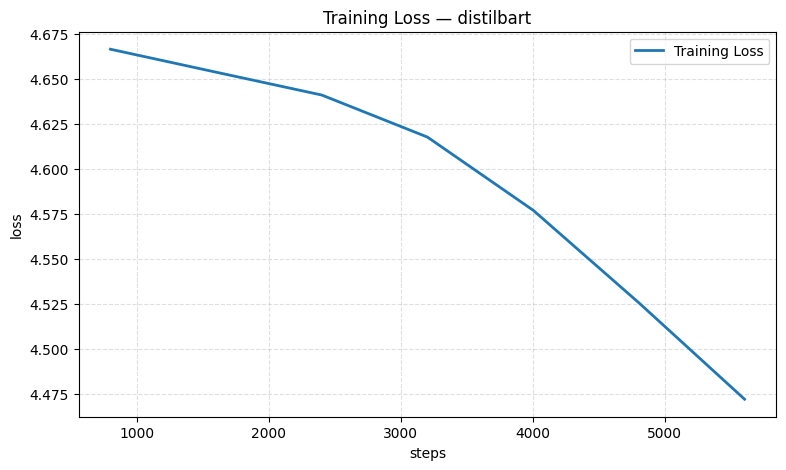

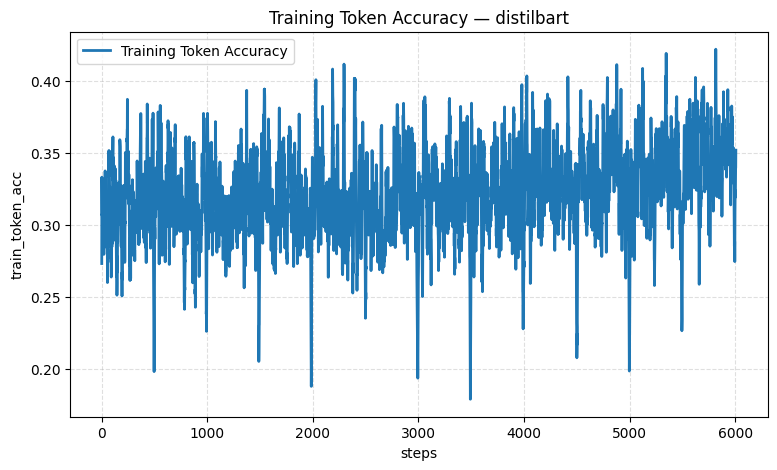

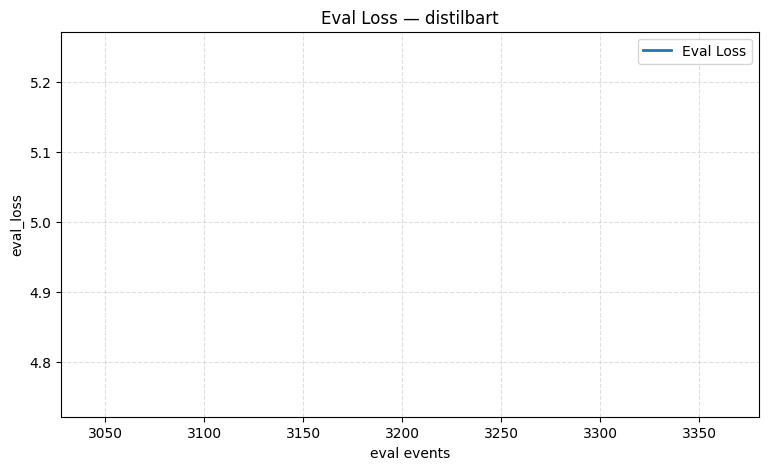


=== Fine-tuning flan_t5_small: google/flan-t5-small ===


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

ValueError: Target module T5LayerNorm() is not supported. Currently, only the following modules are supported: `torch.nn.Linear`, `torch.nn.Embedding`, `torch.nn.Conv2d`, `transformers.pytorch_utils.Conv1D`.

In [ ]:
trainer_dBART, tok_dBART = finetune_generator("distilbart", GENERATORS["distilbart"], out_tag="distilbart")
trainer_FLAN,  tok_FLAN  = finetune_generator("flan_t5_small", GENERATORS["flan_t5_small"], out_tag="flan_t5_small")



=== Fine-tuning (fixed) flan_t5_small_fixed: google/flan-t5-small ===


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training google/flan-t5-small (fixed LoRA targets)...


Step,Training Loss,Validation Loss
200,3.538500,3.974729


Done.


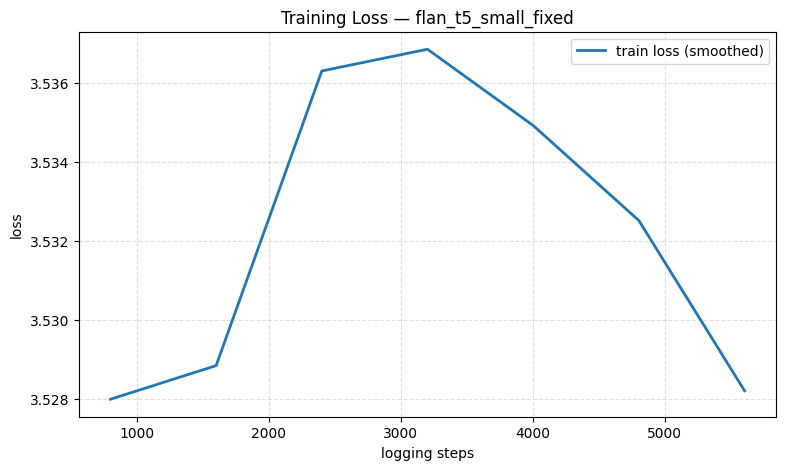

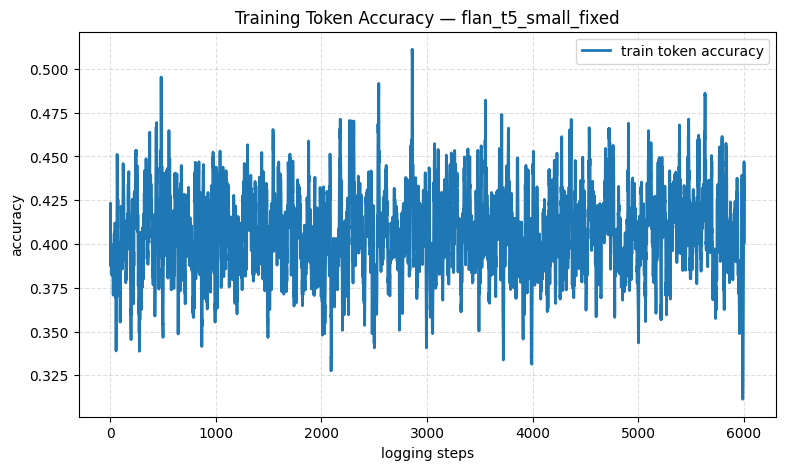

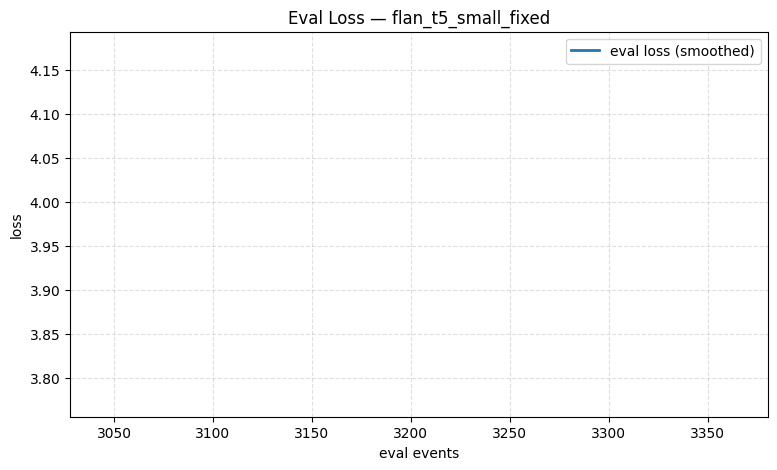

Generating:   0%|          | 0/34 [00:00<?, ?it/s]

Generating:   0%|          | 0/34 [00:00<?, ?it/s]

Generating:   0%|          | 0/34 [00:00<?, ?it/s]

Generating:   0%|          | 0/34 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Extractive: {'rouge1': 0.21454426012402544, 'rouge2': 0.08944646290683668, 'rougeL': 0.11668927367807999, 'rougeLsum': 0.16386130331801105, 'bertscore_f1': 0.8255592584609985}
DistilBART - Abstractive: {'rouge1': 0.30584649920537654, 'rouge2': 0.07836794884581427, 'rougeL': 0.17283552029653215, 'rougeLsum': 0.23600940183909394, 'bertscore_f1': 0.8255721926689148}
DistilBART - Hybrid: {'rouge1': 0.3460195798382153, 'rouge2': 0.09828828659095958, 'rougeL': 0.18949030441656506, 'rougeLsum': 0.26435661332704086, 'bertscore_f1': 0.832582414150238}
FLAN-T5-small (fixed) - Abstractive: {'rouge1': 0.19979974766521305, 'rouge2': 0.045204699127419784, 'rougeL': 0.12649376722748762, 'rougeLsum': 0.16013445924744327, 'bertscore_f1': 0.8092413544654846}
FLAN-T5-small (fixed) - Hybrid: {'rouge1': 0.23641060203071138, 'rouge2': 0.06089315475040402, 'rougeL': 0.14642050842036414, 'rougeLsum': 0.1891943634988479, 'bertscore_f1': 0.8154473900794983}


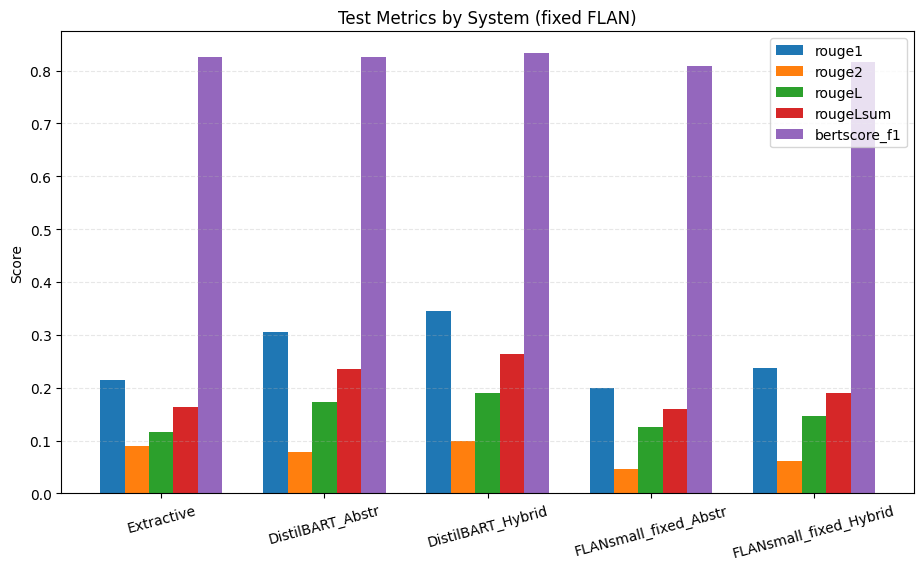

In [ ]:
# You already ran:
# trainer_dBART, tok_dBART = finetune_generator("distilbart", GENERATORS["distilbart"], out_tag="distilbart")
# trainer_FLAN,  tok_FLAN  = finetune_generator("flan_t5_small", GENERATORS["flan_t5_small"], out_tag="flan_t5_small")
# …the second one failed due to T5LayerNorm. Run the block below to ONLY (re)fine-tune FLAN with safe LoRA targets.

# =========================
# 🔧 Re-finetune FLAN-T5-Small ONLY (no LayerNorm in LoRA targets)
# =========================
import gc, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, TrainingArguments
from peft import LoraConfig, get_peft_model
from datasets import Dataset

# Free any partially-initialized FLAN stuff
try:
    del trainer_FLAN, tok_FLAN
except NameError:
    pass
torch.cuda.empty_cache(); gc.collect()

def finetune_flan_fixed(base_model_name="google/flan-t5-small", out_tag="flan_t5_small_fixed"):
    print(f"\n=== Fine-tuning (fixed) {out_tag}: {base_model_name} ===")
    tok = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name, torch_dtype=torch.float32)

    # ✅ T5-safe LoRA targets: NO layer norms
    lora_targets = ["q","k","v","o","wi_0","wi_1","wo"]
    lcfg = LoraConfig(r=16, lora_alpha=32, lora_dropout=0.1,
                      target_modules=lora_targets, bias="none", task_type="SEQ_2_SEQ_LM")
    model = get_peft_model(model, lcfg)

    # memory savers
    try:
        model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
    except TypeError:
        model.gradient_checkpointing_enable()
    if hasattr(model, "enable_input_require_grads"):
        model.enable_input_require_grads()
    model.config.use_cache = False
    model.to(DEVICE)

    # --- Build hybrid inputs for FLAN (prefix "summarize:") using existing extracted/train_df/val_df ---
    def make_src_list(df):
        out = []
        for d, e in zip(df["document"], df["extracted"]):
            s = build_budgeted_hybrid_src(d, e, tok, max_input_len=MAX_INPUT_LEN, frac_shortlist=0.6)
            out.append("summarize: " + s)
        return out

    train_src = make_src_list(train_df); val_src = make_src_list(val_df)

    hf_train = Dataset.from_dict({"src": train_src, "tgt": train_df["summary"].tolist()})
    hf_val   = Dataset.from_dict({"src": val_src,   "tgt": val_df["summary"].tolist()})

    def preprocess(batch):
        enc = tok(batch["src"], max_length=MAX_INPUT_LEN, truncation=True)
        with tok.as_target_tokenizer():
            enc["labels"] = tok(batch["tgt"], max_length=MAX_TARGET_LEN, truncation=True)["input_ids"]
        return enc

    train_tok = hf_train.map(preprocess, batched=True, remove_columns=hf_train.column_names)
    val_tok   = hf_val.map(preprocess,   batched=True, remove_columns=hf_val.column_names)

    data_collator = DataCollatorForSeq2Seq(tokenizer=tok, model=model, pad_to_multiple_of=None)

    # same VRAM-safe args
    EPOCHS, LR = 3, 8e-6
    WARMUP_STEPS, LOGGING_STEPS = 800, 50
    MEM_TRAIN_BS, MEM_ACCUM = 1, 16

    args = TrainingArguments(
        output_dir=os.path.join(OUT_DIR, f"chk_{out_tag}"),
        num_train_epochs=EPOCHS,
        learning_rate=LR,
        weight_decay=0.01,
        warmup_steps=WARMUP_STEPS,
        per_device_train_batch_size=MEM_TRAIN_BS,
        gradient_accumulation_steps=MEM_ACCUM,
        logging_steps=LOGGING_STEPS,
        evaluation_strategy="steps",
        eval_steps=200,
        save_strategy="no",
        fp16=False, bf16=False,
        group_by_length=True,
        dataloader_num_workers=0,
        optim="adamw_torch",
        lr_scheduler_type="constant_with_warmup",
        report_to=[],
        label_smoothing_factor=0.05,
        max_grad_norm=1.0,
    )

    trainer = AccLoggingTrainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        tokenizer=tok,
        data_collator=data_collator,
        compute_metrics=None
    )

    print(f"Training {base_model_name} (fixed LoRA targets)...")
    trainer.train()
    print("Done.")
    torch.cuda.empty_cache(); gc.collect()

    # --- Quick training graphs (reuse same plotting style) ---
    logs = pd.DataFrame(trainer.state.log_history)

    tr = logs[logs["loss"].notnull()].copy()
    if len(tr):
        tr["loss_smooth"] = tr["loss"].rolling(window=10, min_periods=1).mean()
        plt.figure(figsize=(9,5))
        plt.plot(tr["loss_smooth"], label="train loss (smoothed)", linewidth=2)
        plt.title(f"Training Loss — {out_tag}"); plt.xlabel("logging steps"); plt.ylabel("loss")
        plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.show()

    acc = logs[logs.get("train_token_acc").notnull()].copy()
    if len(acc):
        acc["acc_smooth"] = acc["train_token_acc"].rolling(window=10, min_periods=1).mean()
        plt.figure(figsize=(9,5))
        plt.plot(acc["acc_smooth"], label="train token accuracy", linewidth=2)
        plt.title(f"Training Token Accuracy — {out_tag}"); plt.xlabel("logging steps"); plt.ylabel("accuracy")
        plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.show()

    ev = logs[logs.get("eval_loss").notnull()].copy()
    if len(ev):
        ev["eval_loss_smooth"] = ev["eval_loss"].rolling(window=3, min_periods=1).mean()
        plt.figure(figsize=(9,5))
        plt.plot(ev["eval_loss_smooth"], label="eval loss (smoothed)", linewidth=2)
        plt.title(f"Eval Loss — {out_tag}"); plt.xlabel("eval events"); plt.ylabel("loss")
        plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.show()

    return trainer, tok

# ▶️ Run fixed FLAN fine-tune (keeps your DistilBART progress intact)
trainer_FLAN, tok_FLAN = finetune_flan_fixed()

# =========================
# ✅ (Optional) Immediately evaluate both models as before
# =========================
GEN_ARGS = dict(num_beams=5, no_repeat_ngram_size=3, length_penalty=1.8, min_new_tokens=64, early_stopping=True)

# Build test sources
refs      = test_df["summary"].fillna("").tolist()
pred_ext  = test_df["extracted"].fillna("").tolist()

def build_context_only_src_list(df):
    out = []
    for d in df["document"]:
        lead, mid, end = slice_doc_lead_mid_end(d)
        ctx = " ".join([lead, mid, end])
        parts = [f"<title> {(safe_sent_tokenize(d)[:1] or [''])[0]} </title>",
                 f"<keys> {', '.join(safe_sent_tokenize(d)[:5])[:200]} </keys>",
                 f"<context> {ctx} </context>"]
        out.append("\n".join(parts))
    return out

def build_hybrid_src_list(df, tok, is_flan=False):
    L = []
    for d, e in zip(df["document"], df["extracted"]):
        s = build_budgeted_hybrid_src(d, e, tok, max_input_len=MAX_INPUT_LEN, frac_shortlist=0.6)
        if is_flan: s = "summarize: " + s
        L.append(s)
    return L

def score_block(preds, refs):
    r = compute_rouge_table(preds, refs)
    r["bertscore_f1"] = compute_bertscore_f1(preds, refs)
    return r

# DistilBART eval
abstr_src_db = build_context_only_src_list(test_df)
hybrid_src_db= build_hybrid_src_list(test_df, tok_dBART, is_flan=False)
pred_abs_db = batched_generate(trainer_dBART.model, tok_dBART, abstr_src_db, MAX_INPUT_LEN, MAX_TARGET_LEN, batch_size=6, **GEN_ARGS)
pred_hyb_db = batched_generate(trainer_dBART.model, tok_dBART, hybrid_src_db, MAX_INPUT_LEN, MAX_TARGET_LEN, batch_size=6, **GEN_ARGS)

# FLAN eval (fixed)
abstr_src_fl = ["summarize: " + s for s in build_context_only_src_list(test_df)]
hybrid_src_fl= build_hybrid_src_list(test_df, tok_FLAN, is_flan=True)
pred_abs_fl = batched_generate(trainer_FLAN.model, tok_FLAN, abstr_src_fl, MAX_INPUT_LEN, MAX_TARGET_LEN, batch_size=6, **GEN_ARGS)
pred_hyb_fl = batched_generate(trainer_FLAN.model, tok_FLAN, hybrid_src_fl, MAX_INPUT_LEN, MAX_TARGET_LEN, batch_size=6, **GEN_ARGS)

# Scores & plots
res_ext   = score_block(pred_ext, refs)
res_abs_db= score_block(pred_abs_db, refs)
res_hyb_db= score_block(pred_hyb_db, refs)
res_abs_fl= score_block(pred_abs_fl, refs)
res_hyb_fl= score_block(pred_hyb_fl, refs)

print("Extractive:", res_ext)
print("DistilBART - Abstractive:", res_abs_db)
print("DistilBART - Hybrid:", res_hyb_db)
print("FLAN-T5-small (fixed) - Abstractive:", res_abs_fl)
print("FLAN-T5-small (fixed) - Hybrid:", res_hyb_fl)

tbl = pd.DataFrame([
    {"system":"Extractive", **res_ext},
    {"system":"DistilBART_Abstr", **res_abs_db},
    {"system":"DistilBART_Hybrid", **res_hyb_db},
    {"system":"FLANsmall_fixed_Abstr", **res_abs_fl},
    {"system":"FLANsmall_fixed_Hybrid", **res_hyb_fl},
])
tbl.to_csv(os.path.join(OUT_DIR, "test_eval_summary_all_fixed.csv"), index=False)

metrics = ["rouge1","rouge2","rougeL","rougeLsum","bertscore_f1"]
plt.figure(figsize=(11,6))
x = np.arange(len(tbl["system"]))
w = 0.15
for i, m in enumerate(metrics):
    plt.bar(x + (i-2)*w, tbl[m].values, width=w, label=m)
plt.xticks(x, tbl["system"], rotation=15)
plt.title("Test Metrics by System (fixed FLAN)"); plt.ylabel("Score")
plt.grid(True, axis='y', linestyle='--', alpha=0.3); plt.legend(); plt.show()


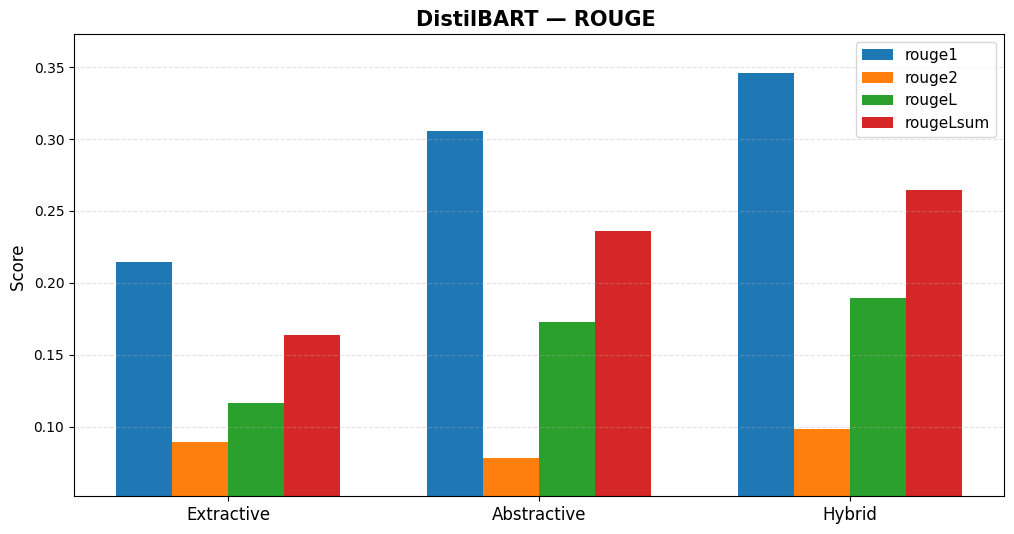

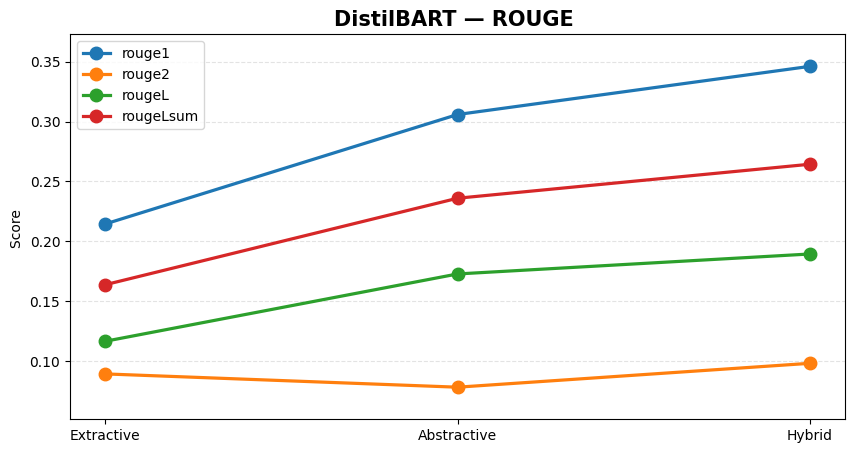

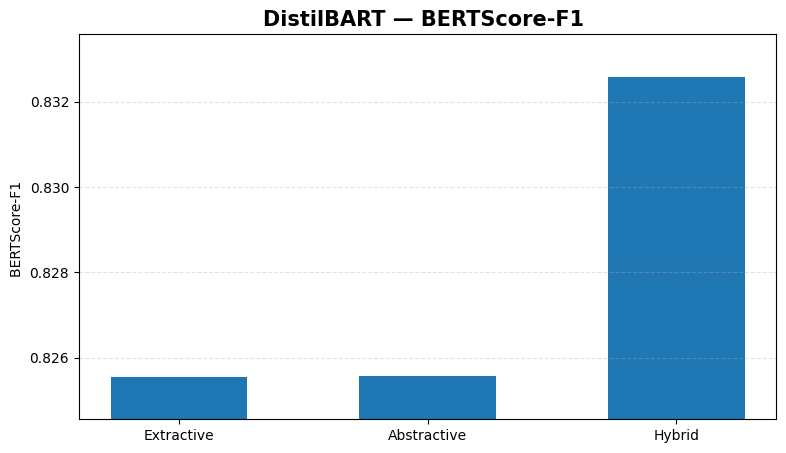

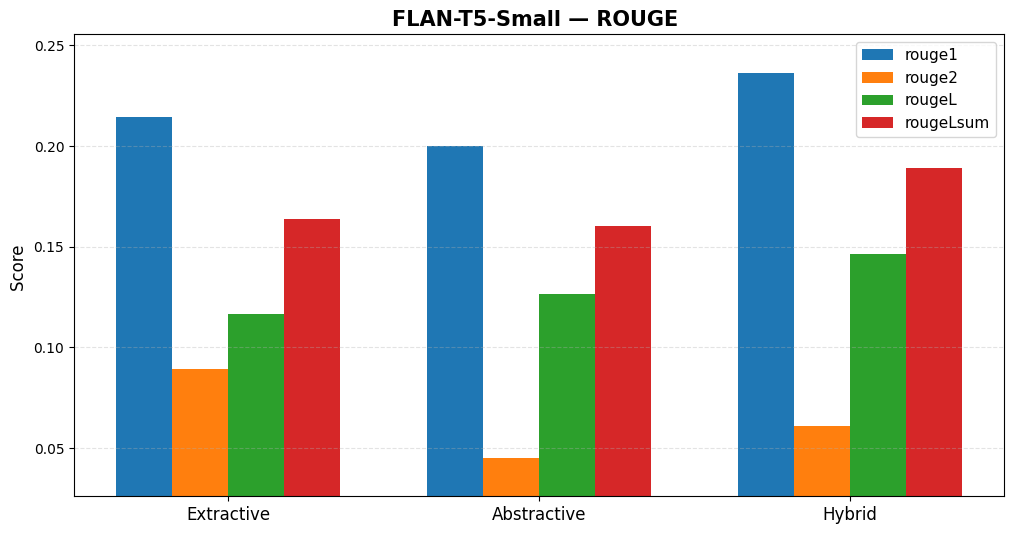

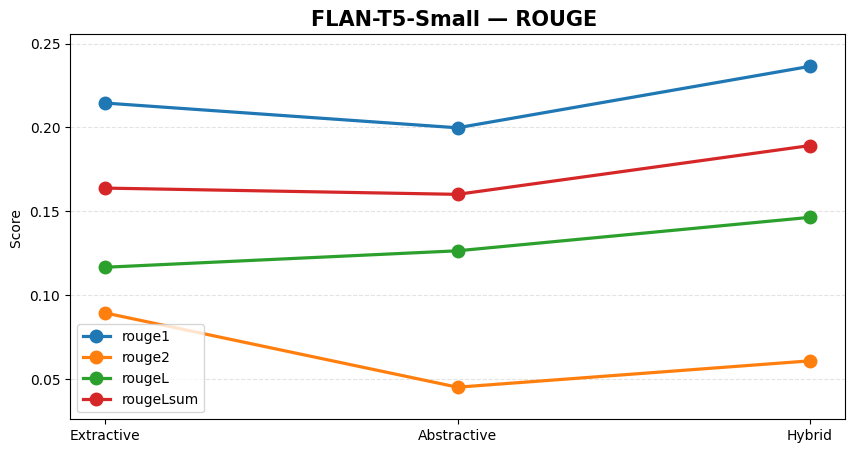

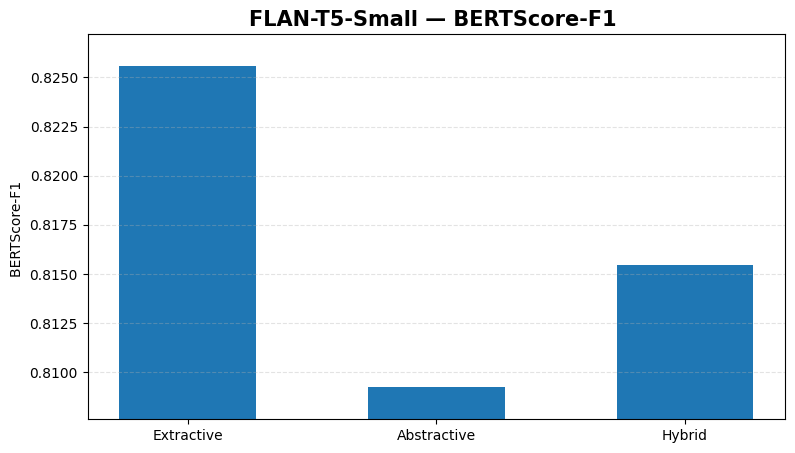

In [ ]:
# =========================
# 📊 High-Contrast Comparison Plots (Visually Amplified)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rouge_metrics = ["rouge1","rouge2","rougeL","rougeLsum"]
bert_metric   = "bertscore_f1"

dbart_tbl = pd.DataFrame([
    {"system":"Extractive", **res_ext},
    {"system":"Abstractive", **res_abs_db},
    {"system":"Hybrid", **res_hyb_db},
])

flan_tbl = pd.DataFrame([
    {"system":"Extractive", **res_ext},
    {"system":"Abstractive", **res_abs_fl},
    {"system":"Hybrid", **res_hyb_fl},
])

def zoom_axis(ax, values, top_pad=0.10, bottom_pad=0.10):
    """Zoom vertically so differences become visually big."""
    vmin, vmax = min(values), max(values)
    spread = vmax - vmin
    if spread < 0.01:  # if scores are too close, force minimum difference
        spread = 0.01
    ax.set_ylim(vmin - spread*bottom_pad, vmax + spread*top_pad)
    ax.grid(True, axis='y', linestyle='--', alpha=0.35)

def plot_zoomed_grouped(df, title):
    df = df.copy().set_index("system")
    systems = df.index.tolist()
    x = np.arange(len(systems))
    w = 0.18

    vals = df[rouge_metrics].values.flatten()

    plt.figure(figsize=(12,6))
    for i, m in enumerate(rouge_metrics):
        plt.bar(x + (i-1.5)*w, df[m].values, width=w, label=m)
    plt.xticks(x, systems, fontsize=12)
    plt.title(title + " — ROUGE ", fontsize=15, weight='bold')
    plt.ylabel("Score ", fontsize=12)
    ax = plt.gca()
    zoom_axis(ax, vals)
    plt.legend(loc="best", fontsize=11)
    plt.show()

def plot_zoomed_lines(df, title):
    df = df.copy().set_index("system")
    plt.figure(figsize=(10,5))
    vals_all = []
    for m in rouge_metrics:
        v = df[m].values
        vals_all.extend(v.tolist())
        plt.plot(df.index, v, marker="o", linewidth=2.3, markersize=9, label=m)
    plt.title(title + " — ROUGE ", fontsize=15, weight='bold')
    plt.ylabel("Score ")
    ax = plt.gca()
    zoom_axis(ax, vals_all)
    plt.legend(loc="best")
    plt.show()

def plot_zoomed_bert(df, title):
    df = df.copy().set_index("system")
    vals = df[bert_metric].values

    plt.figure(figsize=(9,5))
    plt.bar(df.index, vals, width=0.55)
    plt.title(title + " — BERTScore-F1 ", fontsize=15, weight='bold')
    plt.ylabel("BERTScore-F1 ")
    ax = plt.gca()
    zoom_axis(ax, vals)
    plt.show()

# ---------- DistilBART ----------
plot_zoomed_grouped(dbart_tbl, "DistilBART")
plot_zoomed_lines(dbart_tbl,   "DistilBART")
plot_zoomed_bert(dbart_tbl,    "DistilBART")

# ---------- FLAN-T5-Small ----------
plot_zoomed_grouped(flan_tbl,  "FLAN-T5-Small")
plot_zoomed_lines(flan_tbl,    "FLAN-T5-Small")
plot_zoomed_bert(flan_tbl,     "FLAN-T5-Small")
